In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials
results = dict()

data = pd.read_csv('_train_sem09__1_.zip').sample(frac=0.25, random_state=42)
data

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
2148,1,0.100000,0.734427,0.20,0.25,0.136259,0.674081,0.212153,0.512164,0.707647,...,0,0,0,0,0,0,0,0,0,0
1044,1,0.000000,0.372990,0.00,0.00,0.124049,0.608342,0.405229,0.593604,0.737318,...,0,0,0,0,0,0,0,0,0,0
3319,0,0.000000,0.337305,0.00,0.00,0.192214,0.702996,0.281719,0.067800,0.805263,...,0,0,0,0,0,0,0,0,0,0
439,1,0.033300,0.560480,0.05,0.00,0.154026,0.616952,0.228655,0.528427,0.722801,...,0,0,0,0,0,0,0,0,0,0
3516,0,0.033300,0.694001,0.00,0.00,0.280807,0.574624,0.451219,0.705057,0.707184,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,1,0.000000,0.433635,0.00,0.00,0.108839,0.637266,0.419417,0.603541,0.763116,...,0,0,0,0,0,0,0,0,0,0
1667,1,0.000000,0.627946,0.05,0.00,0.188412,0.660975,0.359105,0.587391,0.742754,...,0,0,0,0,0,0,0,0,0,0
568,1,0.000000,0.640995,0.10,0.00,0.153449,0.667856,0.406175,0.568136,0.771680,...,0,0,0,0,0,0,0,0,0,0
3750,0,0.133333,0.533952,0.00,0.00,0.347966,0.757971,0.230667,0.272652,0.854116,...,0,0,0,0,0,0,0,0,0,0


In [31]:
data.isna().sum().sum()

np.int64(0)

In [32]:
data['Activity'].value_counts()

Activity
1    535
0    403
Name: count, dtype: int64

In [33]:
X = data.drop(columns='Activity')
y = data['Activity']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Обучим модели с параметрами по умолчанию

In [35]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

results['LR'] = round(f1_score(y_test, model.predict(X_test)), 5)
print('f1_score на тестовом наборе: {:.5f}'.format(results['LR']))

f1_score на тестовом наборе: 0.78571


In [36]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

results['RF'] = round(f1_score(y_test, model.predict(X_test)), 5)
print('f1_score на тестовом наборе: {:.5f}'.format(results['RF']))

f1_score на тестовом наборе: 0.81081


#### Метод GridSearchCV регрессия:

In [37]:
param_grid = {'penalty': ['l2', None] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid,
    cv=5,
    n_jobs = -1
)  

grid_search.fit(X_train, y_train) 
y_pred = grid_search.predict(X_test)
results['LR GridSearchCV'] = round(f1_score(y_test, y_pred), 5)
print('f1_score на тестовом наборе: {:.5f}'.format(results['LR GridSearchCV']))
print("Наилучшие значения гиперпараметров:", grid_search.best_params_)

f1_score на тестовом наборе: 0.78571
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs'}


#### Метод GridSearchCV случайный лес:

In [38]:
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25],
              'criterion':['entropy','gini']
              }
            

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train) 
y_pred = grid_search.predict(X_test)
results['RF GridSearchCV'] = round(f1_score(y_test, y_pred), 5)
print('f1_score на тестовом наборе: {:.5f}'.format(results['RF GridSearchCV']))
print("Наилучшие значения гиперпараметров:", grid_search.best_params_)

f1_score на тестовом наборе: 0.81057
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 100}


#### Метод RandomizedSearchCV регрессия:

In [39]:
param_distributions = {'penalty': ['l2', None] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))
               }
            

grid_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_distributions=param_distributions,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train) 
y_pred = grid_search.predict(X_test)
results['LR RandomizedSearchCV'] = round(f1_score(y_test, y_pred), 5)
print('f1_score на тестовом наборе: {:.5f}'.format(results['LR RandomizedSearchCV']))
print("Наилучшие значения гиперпараметров:", grid_search.best_params_)

f1_score на тестовом наборе: 0.80357
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': np.float64(0.34)}


#### Метод RandomizedSearchCV случайный лес:

In [40]:
param_distributions = {'n_estimators': list(range(100, 200, 10)),
              'min_samples_leaf': list(np.linspace(1, 10, 10, dtype=int)),
              'max_depth': list(np.linspace(1, 40, 40, dtype=int)),
              'criterion':['entropy','gini']
              }
            

grid_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train) 
y_pred = grid_search.predict(X_test)
results['RF RandomizedSearchCV'] = round(f1_score(y_test, y_pred), 5)
print('f1_score на тестовом наборе: {:.5f}'.format(results['RF RandomizedSearchCV']))
print("Наилучшие значения гиперпараметров:", grid_search.best_params_)

f1_score на тестовом наборе: 0.81778
Наилучшие значения гиперпараметров: {'n_estimators': 130, 'min_samples_leaf': np.int64(2), 'max_depth': np.int64(26), 'criterion': 'entropy'}


#### Метод Hyperopt регрессия:

In [41]:
def hyperopt_rf(params, X=X_train, y=y_train):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = RandomForestClassifier(**params, random_state=42)
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

def hyperopt_lr(params, X=X_train, y=y_train):
    # функция получает комбинацию гиперпараметров в "params"
    params = { 'solver': params['solver'], 'C': params['C']}
  
    # используем эту комбинацию для построения модели
    model = LogisticRegression(**params, penalty='l2', random_state=42, max_iter=10000)

    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [42]:
space = {
        'solver': hp.choice('solver', ['lbfgs', 'sag']),
        'C': hp.quniform('C', 0.01, 10, 0.1)
}

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_lr,
            space=space,
            max_evals=20,
            algo=tpe.suggest,
            trials=trials,
            rstate=np.random.default_rng(42)
            )

# best['solver'] возвращает индекс параметра в листе, переданном hp.choice
print("Наилучшие значения гиперпараметров ", best, ', best solver: ', ['lbfgs', 'sag'][best['solver']])

100%|██████████| 20/20 [01:11<00:00,  3.56s/trial, best loss: -0.7747812752219532]
Наилучшие значения гиперпараметров  {'C': np.float64(0.4), 'solver': np.int64(0)} , best solver:  lbfgs


In [43]:
model = LogisticRegression(penalty='l2', solver=['lbfgs', 'sag'][best['solver']], C=best['C'] , random_state=42, max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
results['LR Hyperopt'] = round(f1_score(y_test, y_pred), 5)
print('f1_score на тестовом наборе: {:.5f}'.format(results['LR Hyperopt']))

f1_score на тестовом наборе: 0.80357


#### Метод Hyperopt случайный лес:

In [44]:
space={'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
       'max_depth' : hp.quniform('max_depth', 10, 200, 5),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(42)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [00:17<00:00,  1.16trial/s, best loss: -0.7937864048349323]
Наилучшие значения гиперпараметров {'max_depth': np.float64(125.0), 'min_samples_leaf': np.float64(4.0), 'n_estimators': np.float64(230.0)}


In [45]:
model = RandomForestClassifier(
    random_state=42, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
results['RF Hyperopt'] = round(f1_score(y_test, y_pred), 5)
print('f1_score на тестовом наборе: {:.5f}'.format(results['RF Hyperopt']))

f1_score на тестовом наборе: 0.80702


#### Метод Optuna регрессия:

In [46]:
import optuna

In [47]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 300, step=10)
    max_depth = trial.suggest_int('max_depth', 15, 40, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, step=1)

    # создаем модель
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=42)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

    return score

def optuna_lr(trial):
    # задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty',  ['l2', None])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
    C = trial.suggest_float('C', 0.05, 1, step=0.05)
    
    # создаем модель
    model = LogisticRegression(penalty=penalty,
                               solver=solver,
                               C=C,
                               random_state=42,
                               max_iter=5000)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

    return score

In [48]:
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=20)

[I 2025-02-04 23:51:15,005] A new study created in memory with name: LogisticRegression
[I 2025-02-04 23:51:16,351] Trial 0 finished with value: 0.7730758965086745 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.05}. Best is trial 0 with value: 0.7730758965086745.
[I 2025-02-04 23:51:18,250] Trial 1 finished with value: 0.7675755292952295 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.6000000000000001}. Best is trial 0 with value: 0.7730758965086745.
[I 2025-02-04 23:51:20,886] Trial 2 finished with value: 0.7618174535219435 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 1.0}. Best is trial 0 with value: 0.7730758965086745.
[I 2025-02-04 23:51:22,477] Trial 3 finished with value: 0.7750150616965346 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.5}. Best is trial 3 with value: 0.7750150616965346.
[I 2025-02-04 23:51:43,508] Trial 4 finished with value: 0.7280437200305656 and parameters: {'penalty': None, 'solver': 'sag', 'C': 0.15000000000000002}

In [49]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.5f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.35000000000000003}
f1_score на обучающем наборе: 0.77935


In [50]:
model = LogisticRegression(**study.best_params, random_state=42, max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
results['LR Optuna'] = round(f1_score(y_test, y_pred), 5)
print('f1_score на тестовом наборе: {:.5f}'.format(results['LR Optuna']))

f1_score на тестовом наборе: 0.80357


#### Метод Optuna случайный лес:

In [51]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2025-02-04 23:52:33,428] A new study created in memory with name: RandomForestClassifier
[I 2025-02-04 23:52:34,270] Trial 0 finished with value: 0.7878339907330869 and parameters: {'n_estimators': 270, 'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7878339907330869.
[I 2025-02-04 23:52:34,886] Trial 1 finished with value: 0.7906906571222907 and parameters: {'n_estimators': 140, 'max_depth': 17, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7906906571222907.
[I 2025-02-04 23:52:35,506] Trial 2 finished with value: 0.7900639469281872 and parameters: {'n_estimators': 150, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.7906906571222907.
[I 2025-02-04 23:52:36,001] Trial 3 finished with value: 0.7909130275137483 and parameters: {'n_estimators': 100, 'max_depth': 35, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.7909130275137483.
[I 2025-02-04 23:52:37,004] Trial 4 finished with value: 0.7851861529688646 and parameters: {'n_

In [52]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.5f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 160, 'max_depth': 17, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.79374


In [53]:
model = RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
results['RF Optuna'] = round(f1_score(y_test, y_pred), 5)
print('f1_score на тестовом наборе: {:.5f}'.format(results['RF Optuna']))

f1_score на тестовом наборе: 0.83036


In [54]:
results

{'LR': 0.78571,
 'RF': 0.81081,
 'LR GridSearchCV': 0.78571,
 'RF GridSearchCV': 0.81057,
 'LR RandomizedSearchCV': 0.80357,
 'RF RandomizedSearchCV': 0.81778,
 'LR Hyperopt': 0.80357,
 'RF Hyperopt': 0.80702,
 'LR Optuna': 0.80357,
 'RF Optuna': 0.83036}

<Axes: >

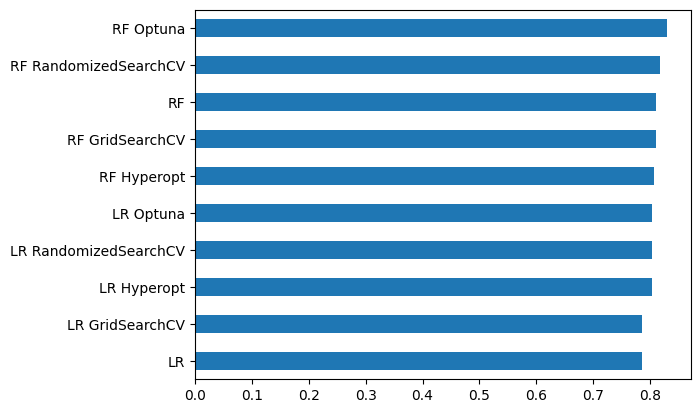

In [55]:
pd.Series(results).sort_values().plot(kind='barh')